In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
df = pd.read_csv('C:/Users/Sayantan Kuila/Desktop/New folder/train.csv')

In [4]:
from tensorflow.keras.layers import TextVectorization

In [5]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [6]:
X

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

In [7]:
MAX_FEATURES = 200000

In [8]:
vectorizer = TextVectorization(max_tokens = MAX_FEATURES,
                              output_sequence_length=1800,
                              output_mode = 'int')

In [9]:
vectorizer.adapt(X.values)

In [10]:
vectorizer('hello world, life is great')[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([286, 261, 305,   9, 275], dtype=int64)>

In [11]:
vectorized_text = vectorizer(X.values)
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  643,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2506, ...,     0,     0,     0],
       [  425,   440,    70, ...,     0,     0,     0],
       ...,
       [32141,  7329,   383, ...,     0,     0,     0],
       [    5,    12,   533, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]], dtype=int64)>

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text , y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [13]:
 len(dataset)

9974

In [14]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [16]:
model = Sequential()
model.add(Embedding(MAX_FEATURES +1 , 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))

model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dense(6, activation='sigmoid'))

In [17]:
model.compile(loss = 'BinaryCrossentropy' , optimizer = 'Adam')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [19]:
history = model.fit(train, epochs = 1 , validation_data = val)

6981/6981 [==============================] - 2524s 359ms/step - loss: 0.0628 - val_loss: 0.0459


In [20]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

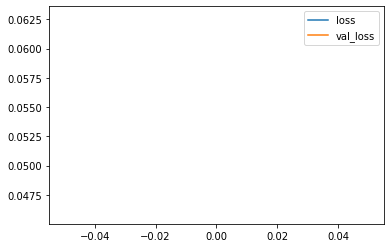

In [22]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [31]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [32]:
input_text = vectorizer('i hate you, you are black')
model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 192ms/step


array([[0.92501485, 0.0386769 , 0.58349186, 0.03169319, 0.48961893,
        0.06789365]], dtype=float32)

In [28]:
input_text = vectorizer('you freaking suck die')
model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 196ms/step


array([[0.99960595, 0.28046346, 0.9870358 , 0.02381063, 0.8978969 ,
        0.14292309]], dtype=float32)

In [33]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [34]:
(model.predict(batch_X) > 0.5).astype(int)


1/1 [==============================] - 0s 291ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [35]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy


In [36]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [40]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)


1/1 [==============================] - 0s 115ms/step


In [41]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8493898510932922, Recall:0.6505164504051208, Accuracy:0.492691308259964
